In [22]:
import numpy as np
import pandas as pd
import json
import os

In [35]:
files = [os.path.join("tables", item) for item in os.listdir("tables") if item.endswith(".json")]
table_headings = [
    "variable",
    "units",
    "baseline-no-ML",
    "temperature-moisture-RF",
    "temperature-moisture-winds-RF",
    "temperature-moisture-winds-prescribed-sfc-RF",
    "temperature-moisture-winds-prescribed-sfc-NN-ensemble",
    "temperature-moisture-prescribed-sfc-RF",
    "temperature-moisture-prescribed-sfc-NN-ensemble",
]


ablation_data = []
for file in files:
    with open(file, "r") as f:
        data = json.load(f)
    if isinstance(data, dict):
        data = [data]
    for entry in data:
        variable_data = []
        
        for column in table_headings:
            variable_data.append(entry[column])
        ablation_data.append(variable_data)


In [36]:
df = pd.DataFrame(ablation_data, columns=table_headings)
df

,variable,units,baseline-no-ML,temperature-moisture-RF,temperature-moisture-winds-RF,temperature-moisture-winds-prescribed-sfc-RF,temperature-moisture-winds-prescribed-sfc-NN-ensemble,temperature-moisture-prescribed-sfc-RF,temperature-moisture-prescribed-sfc-NN-ensemble
0,h500_rms_global_day5_ic_mean,m,46.237999,44.717102,38.514500,38.415798,39.265022,45.025906,44.601345
1,h500_rms_global_day5_ic_std,m,1.105842,1.112559,2.390691,2.373155,1.001811,1.029212,0.839910
2,tmp850_rms_global_day5_ic_mean,K,2.418745,2.199517,2.213602,2.143891,2.022142,2.126498,2.064280
3,tmp850_rms_global_day5_ic_std,K,0.081934,0.068285,0.082298,0.060540,0.043612,0.060621,0.058184
4,tmp200_rms_global_day5_ic_mean,K,2.397740,2.135306,2.863967,2.900081,2.441884,2.134798,2.137587
5,tmp200_rms_global_day5_ic_std,K,0.073854,0.057906,0.258688,0.265248,0.168340,0.062779,0.086025
6,global_surface_precipitation_rmse,mm/day,3.655571,2.659678,2.722468,2.568616,2.527530,2.538595,2.556271
7,land_surface_precipitation_bias,mm/day,1.093459,0.796128,0.937544,0.359086,0.002964,0.115097,0.036406


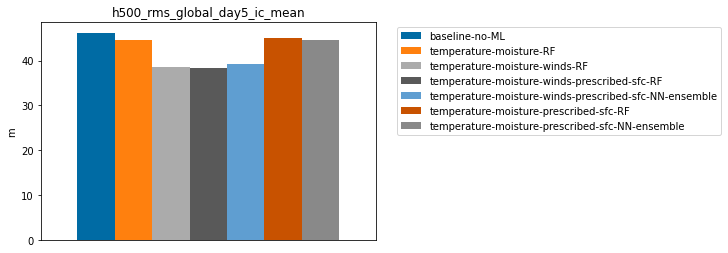

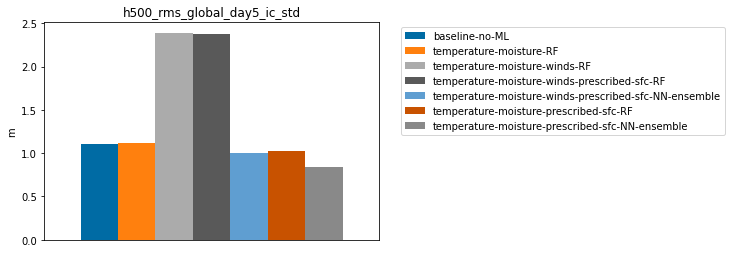

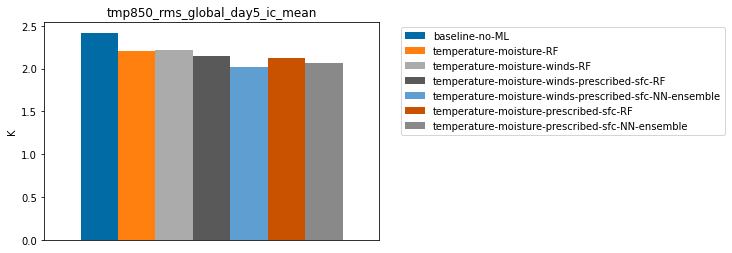

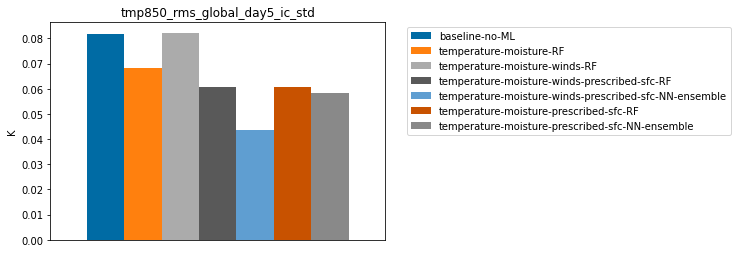

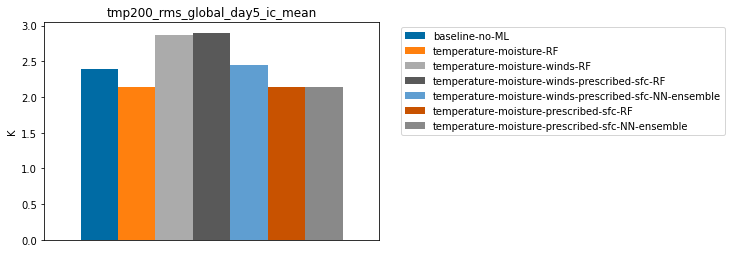

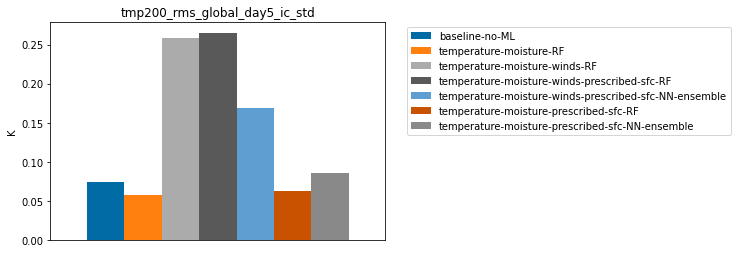

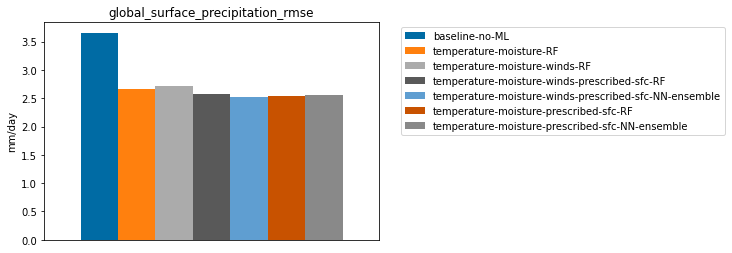

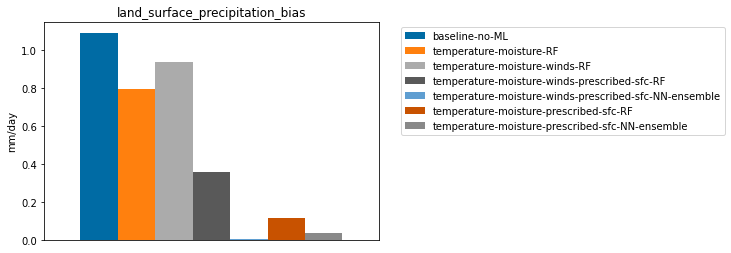

In [58]:
import matplotlib.pyplot as plt

for variable in df["variable"].values:
    row = df.loc[ df["variable"] == variable] 
    ax = row.plot(kind='bar', width=1.8)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_ylabel(row["units"].values[0])
    ax.get_xaxis().set_visible(False)
    ax.set_title(variable)


#### Can copy/paste this output into the latex document.

In [33]:

print(
    df.to_latex(
        index=False, 
        float_format="{:0.2f}".format,
    )
)

\begin{tabular}{llrrrrrr}
\toprule
                          variable &   units &  baseline-no-ML &  temperature-moisture-RF &  temperature-moisture-winds-RF &  temperature-moisture-winds-prescribed-sfc-RF &  temperature-moisture-winds-prescribed-sfc-NN-ensemble &  temperature-moisture-prescribed-sfc-RF \\
\midrule
      h500\_rms\_global\_day5\_ic\_mean &       m &           46.24 &                    44.72 &                          38.51 &                                         38.42 &                                              39.27 &                                   45.03 \\
       h500\_rms\_global\_day5\_ic\_std &       m &            1.11 &                     1.11 &                           2.39 &                                          2.37 &                                               1.00 &                                    1.03 \\
    tmp850\_rms\_global\_day5\_ic\_mean &       K &            2.42 &                     2.20 &                           2.21 &      